# Data Сollection

In [1]:
import time
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json
import matplotlib


# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [2]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cat
0,40585382,1
1,30005269,0
2,3314758074,0
3,14311688,0
4,110457801,0


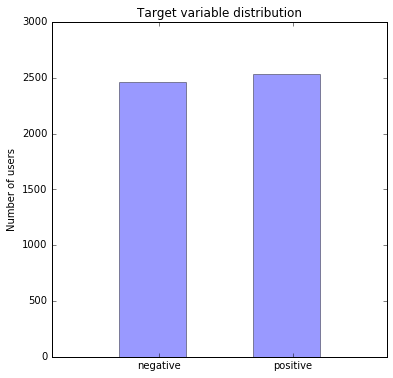

In [3]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cat"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

In [4]:
CONSUMER_KEY = "YuPZpGFwYIuozchukUq8HJjSo"
CONSUMER_SECRET = "ejXbxQnh4mYT95U80lmKuf1fplQmr7UkgqDTDJjfMAAoGZemuz"

ACCESS_TOKEN_KEY = "703233763111780352-B4pLHq5RQTQqRSQRWDNUqtksu7bIspP"
ACCESS_TOKEN_SECRET = "N3JkQVBR27P7oqfV2BZmDkT1lypMoe52KBXUDnSFRQrWO"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничего 30к в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [5]:
GEO_USER_NAME = "danazl"

def get_coordinates_by_location(location):    
    """
    This function gets geographic coordinates and city name
    form external web service GeoNames using 'location' string.
    
    NOTE: the returned value is FAKE. It's only used to show
    NOTE: correct output format.
    """
    # your code here
    try:
        response = requests.get('http://api.geonames.org/searchJSON?q='+location+'&maxRows=10&username=danazl')
    except Exception as error:
        if error[0]['code'] == 20 or error[0]['code'] == 19 or error[0]['code'] == 18 :
            print "Wait,request limit exceeded :("
        return
    response_python = json.loads(response.text)      
    if 'geonames' not in response_python:               #check the correctness of the answer:
        return(nan, nan, nan)
    if len(response_python['geonames']) == 0:
        return (nan, nan, nan)
    if 'lng' not in response_python['geonames'][0]:
        lng = nan
    else: lng = response_python['geonames'][0]['lng']
        
    if 'lat' not in response_python['geonames'][0]:
        lat = nan
    else: lat = response_python['geonames'][0]['lat']
        
    if 'countryName' not in response_python['geonames'][0]:
        country = nan
    else: country = response_python['geonames'][0]['countryName']
    
    return (lng, lat, country)



Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [6]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None
    
user_records = []
tmp_file_name = 'tmp_user_records'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')
             
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lon"], record["lat"], record["country"] = get_coordinates_by_location(user.location)
    
    return record


def get_user_records(df):
    # some_downloaded_user = get_user_from_api
    # also write user as json line in temporary file
    # return [twitter_user_to_dataframe_record(some_downloaded_user)]
    global user_records
    cnt = 0
    for i in df["uid"]:
        cnt = cnt+1
      
        if i not in processed_users:
            try:
                user = api.GetUser(user_id = i)
            except twitter.TwitterError as exc:
                if ('code' in exc[0][0]) and (exc[0][0][u'code'] == 50 or exc[0][0][u'code'] == 63):  #Error: "User not found" or "User has been suspended"
                    continue
                if ('code' in exc[0][0]) and (exc[0][0][u'code'] == 88):   #Error: "Request limit exceeded"
                    print "Wait"                                           #Wait 15 minutes and continue
                    time.sleep(1000)
                    continue
                continue
                    
            user_rcd = twitter_user_to_dataframe_record(user)
            json.dump(user_rcd, f)
            f.write('\n')
            #print "write: ", cnt
            user_records.append(user_rcd)
            processed_users.add(user_rcd["uid"])
        #else:
            #print "check: ", cnt
    return user_records    

# Maximum number of user IDs returned by Twitter's user lookup
    
user_records = get_user_records(df_users)
f.close()

        
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

Creating data frame from loaded data
Merging data frame with the training set
Finished building data frame


## Exploratory Data Analysis

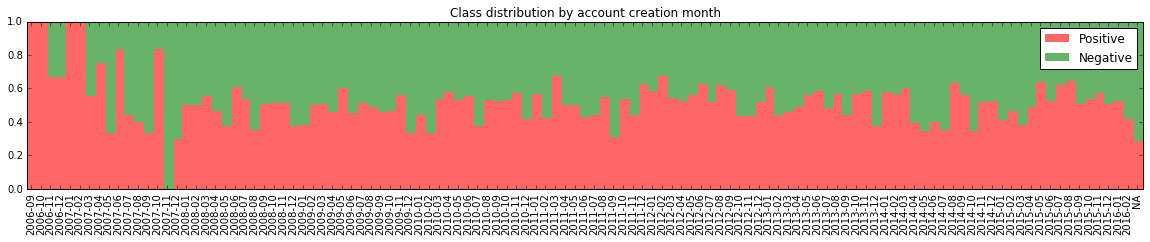

In [7]:
def count_users(grouped):
    """
    Counts number of positive and negative users
    created at each date.
    
    Returns:
        count_pos -- 1D numpy array with the counts of positive users created at each date
        count_neg -- 1D numpy array with the counts of negative users created at each date
        dts -- a list of date strings, e.g. ['2014-10', '2014-11', ...]
        
    """
        
    df_cnt = grouped["cat"].count().values
    df_sum = grouped["cat"].sum().values
    
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    
    count_pos = df_sum
   
    count_neg = df_cnt - count_pos
    
    dts = grouped.groups.keys()
    dts.sort()
    
    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))

count_pos, count_neg, dts = count_users(grouped)

fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()


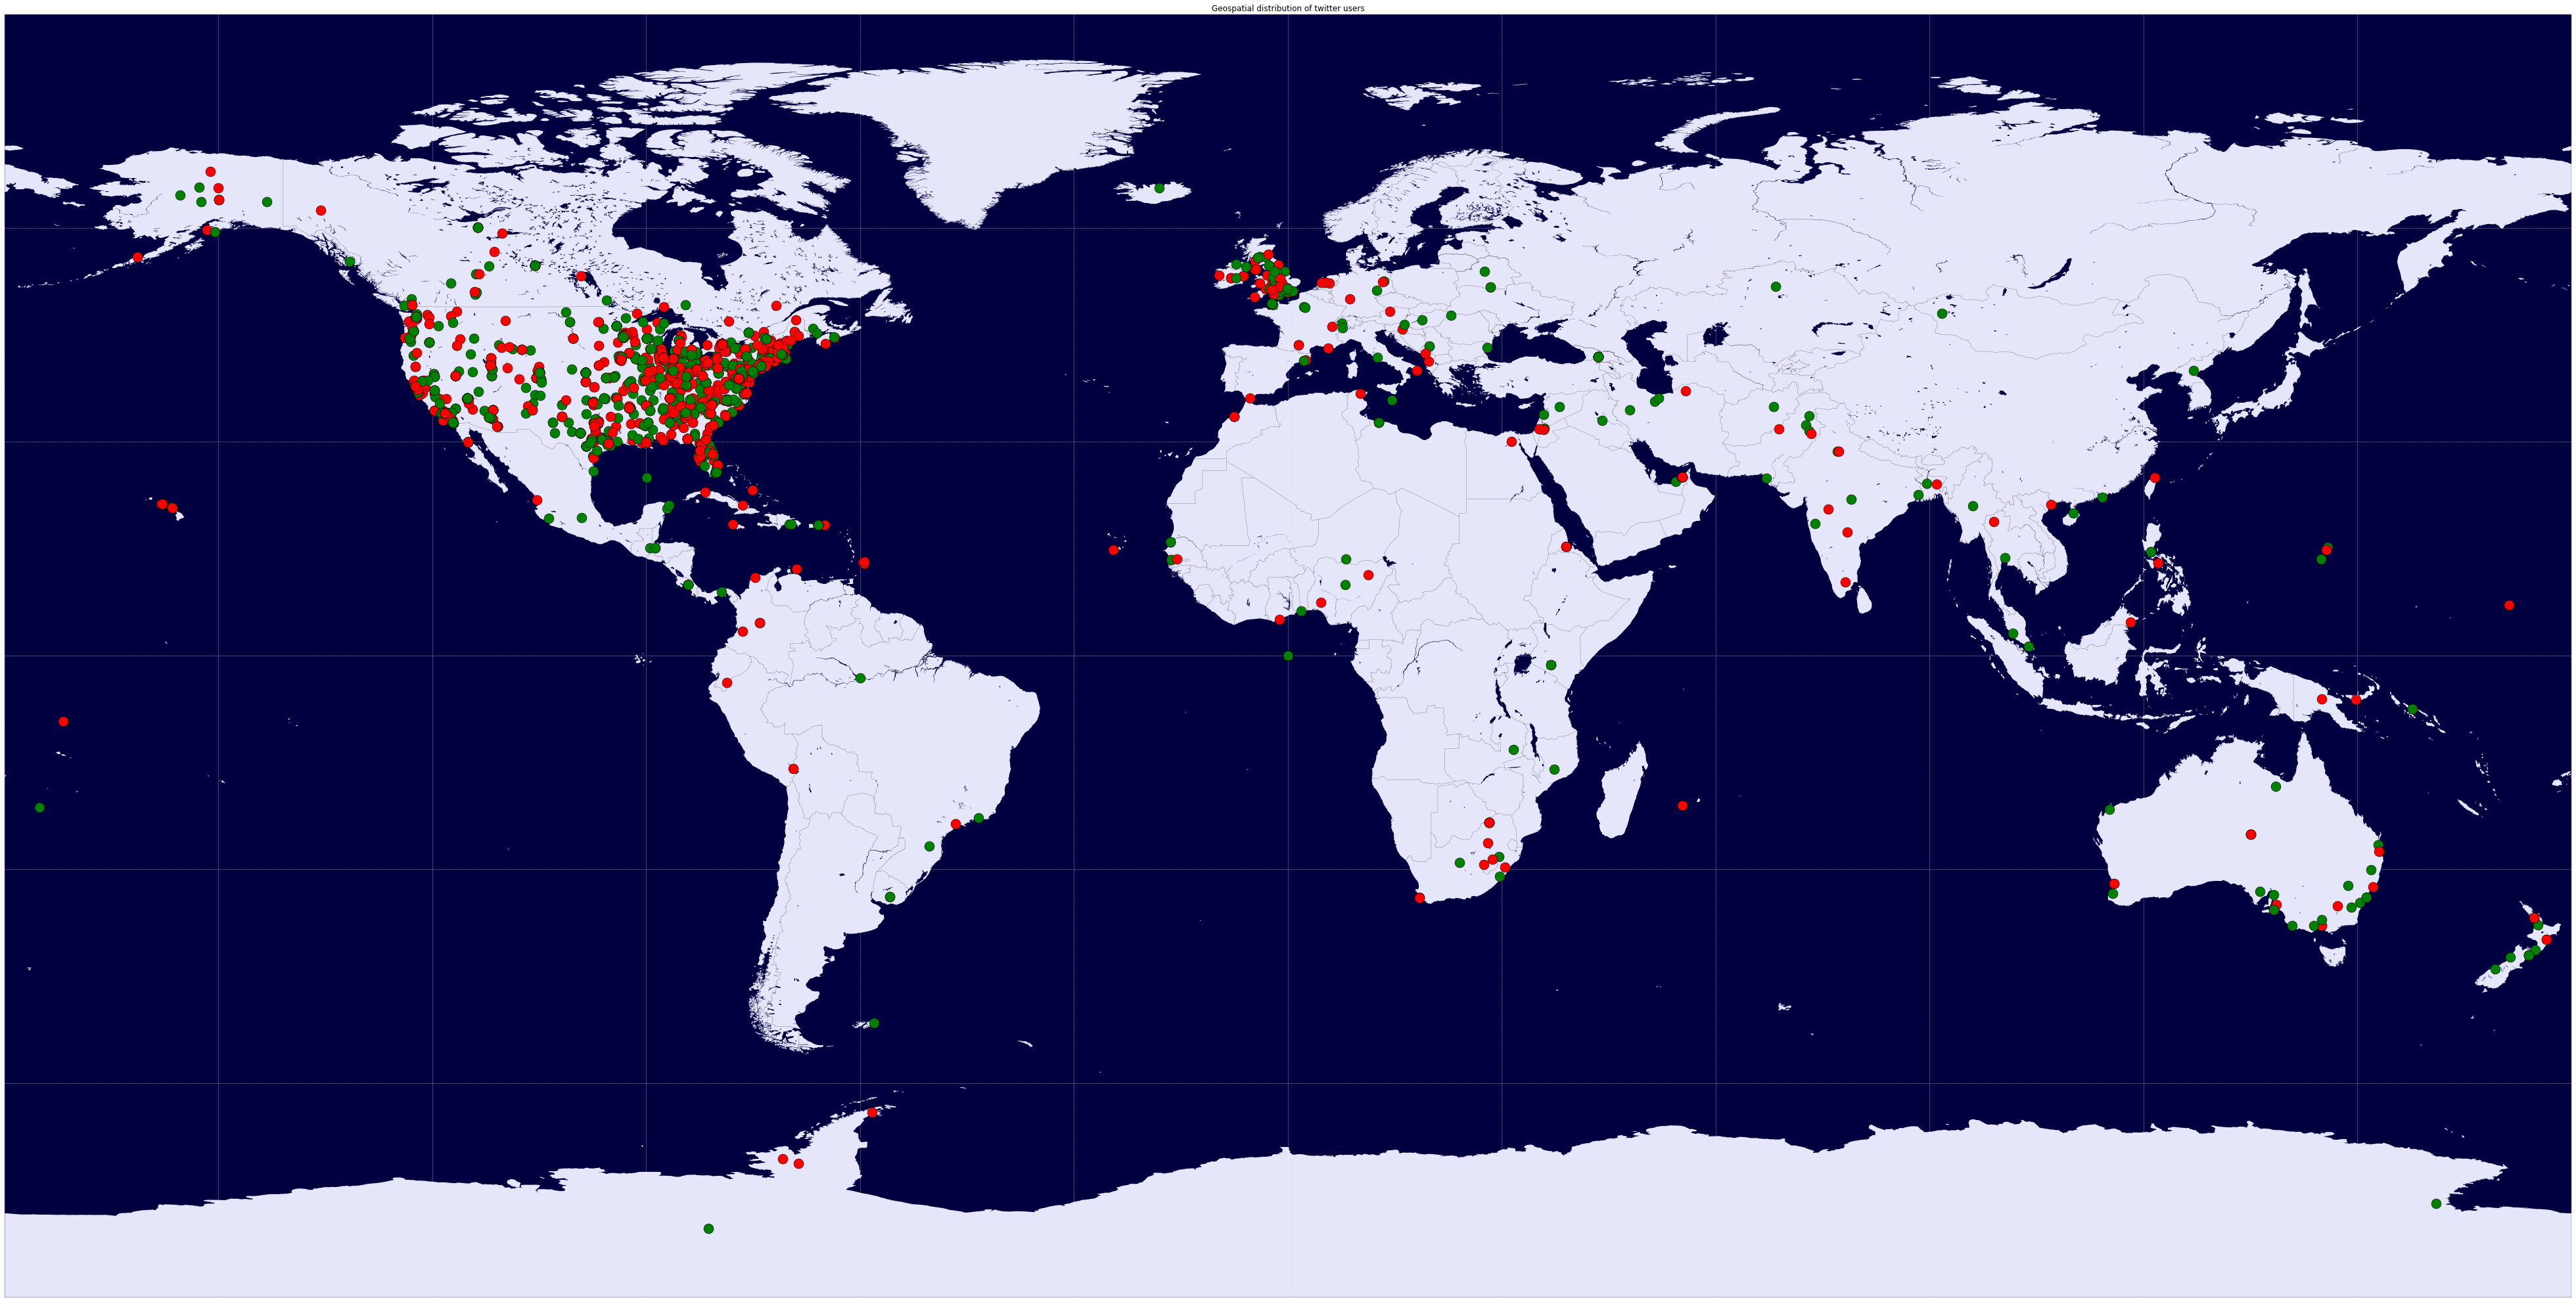

In [10]:
pl.figure(figsize=(70,62))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='i')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(df_full):
    """
    Plot points on the map
    """
    df_buf = df_full.dropna(subset=["cat", "lat", "lon"])
    
    for index, row in df_buf.iterrows():
        x, y = float(row["lon"]), float(row["lat"])
        if row["cat"] == 1.0:
            m.plot(x, y, 'o', c='r', markersize = 15)
        else:
            m.plot(x, y, 'o', c='g',  markersize = 15)
    return

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

In [11]:
OUT_FILE_PATH = "hw1_out.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out.csv


,uid,cat,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,40585382,1,Reverend Sue,ReverendSue,Retired Interfaith Minister. Activist. Equalit...,False,United States,39.76,-98.5,United States,2009-05,7616,4283,50626,787,417
1,30005269,0,Ryan Wrasse,RWrasse,Communications Director for @SenJohnThune | Ge...,False,Capitol Hill,15.20825,145.75313,Northern Mariana Islands,2009-04,1911,1240,7139,128,96
2,3314758074,0,Campaign Trump,Campaign_Trump,Moving on to #SuperTuesday. Indp. Local & Inte...,False,"Houston, TX",29.76328,-95.36327,United States,2015-08,18143,12455,991,7055,159
3,14311688,0,Bernard Whitman,BernardWhitman,"Democratic strategist, pollster, and corporate...",False,New York,40.71427,-74.00597,United States,2008-04,1757,1292,7332,157,111
4,110457801,0,Carson Ingle,caingle,Writer for @AthleteSpeakers & @NOPACTalent. 10...,False,Orlando aka The City Beautiful,None,None,None,2010-02,1467,1189,37100,3310,79
